# LSTM et CNN pour la classification de textes
## Analyse de sentiments appliquée à des tweets en français

Issu du concours académique DEFT'2017<br/>
https://deft.limsi.fr/2017/

In [1]:
%pylab inline

pylab.rcParams['figure.figsize'] = (15.0, 10.0)
pylab.rcParams['figure.dpi'] = 150

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("max_colwidth", 999)

In [4]:
import numpy as np
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


## Chargement de la donnée
On prendra comme jeu de données celui concernant les tweets figuratifs. Il s'agit ici de détecter si un tweet utilise du langage figuratif ou non. On s'intéresse à trois phénomènes : l'ironie, le sarcasme et l'humour. Si un tweet contient au moins une expression relevant de ces phénomènes, il est considéré comme figuratif, sinon il est considéré non figuratif.

In [5]:
X = pd.read_csv('../data/deft2017/task2-train.csv',skiprows=10, sep='\t', header=None, encoding='utf-8', quoting=3)
X.columns = ['id','text','class']
X = X.set_index('id')
X = X.reset_index(drop=True)

In [6]:
X.head(5)

,text,class
0,Train de vie des ministères : Fillon conteste les chiffres http://tinyurl.com/y89zgkk Qui ment? (),figurative
1,Un complot sioniste pour augmenter les accidents mortels en Tunisie http://snipr.com/ua2dw,figurative
2,[rp-fr][Numerama] La Chine rejoint l'Inde pour s'opposer à l'ACTA http://ur1.ca/05rxl,figurative
3,LeGvnt maitrise la situation RT @cedricgarrofe Incendies en Russie: état d'urgence autour d'un centre nucléaire http://bit.ly/doqgSq,figurative
4,Chanceux! RT @lemondefr Le patron de Google reçu par Nicolas Sarkozy http://bit.ly/aYrNCx,figurative


Un peu de remise en forme de la donnée (cible, netoyage):

In [7]:
X['class_cat'] = X['class'].map(lambda x : 1 if x == 'figurative' else 0).astype("str")

In [10]:
X['text'] = X['text'].str.encode('utf-8')

In [9]:
import re

def parse_tweet(text):
    text = text.replace('@', '')
    text = text.replace('#', '')
    text = text.replace('\n', '')
    text = text.replace('\r','')
    
    urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)
    for url in urls:
        text = text.replace(url,'url')

    return text

On nettoie rapidement le texte, et on remplace tous les URLs par un même mot clé.

In [11]:
X['text'] = X['text'].astype("str").map(lambda x : parse_tweet(x))

In [13]:
import string

def remove_punct(text):
    for p in string.punctuation:
        text = text.replace(p, ' ')
    text = ' '.join(text.split())
    return text

On retire la ponctuation et on passe tout en minuscule. Ce n'est pas forcément une bonne idée d'enlever toute la ponctuation dans le cas d'un problème d'analyse de sentiment, mais cela fera l'affaire pour ce tutoriel.

In [14]:
X['text'] = X['text'].map(lambda x: remove_punct(x))
X['text'] = X['text'].map(lambda x: x.lower())
X['text'] = X['text'].str.decode('utf8')

In [126]:
X.head(5)

,text,class,class_cat
0,train de vie des ministères fillon conteste les chiffres url qui ment,figurative,1
1,un complot sioniste pour augmenter les accidents mortels en tunisie url,figurative,1
2,rp fr numerama la chine rejoint l inde pour s opposer à l acta url,figurative,1
3,legvnt maitrise la situation rt cedricgarrofe incendies en russie état d urgence autour d un centre nucléaire url,figurative,1
4,chanceux rt lemondefr le patron de google reçu par nicolas sarkozy url,figurative,1


On construit nos jeux de train et test.

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X['text'], X['class_cat'], test_size=0.2, random_state=42)

In [35]:
print(X_train.shape)
print(X_test.shape)

(4682,)
(1171,)


## Pipeline LSTM

### Text2Sequence

Une fois le texte nettoyé, on va effetuer plusieurs étapes pour transformer la donnée et la passer en entrée au réseau de neurones:
<ul> 
<li>**Tokenization**: `'comment est votre blanquette'` devient `['comment', 'est', 'votre', 'blanquette']`</li>
<li>**Stemming**: pour réduire le vocabulaire, on ne garde que la racine des mots. `['comment', 'est', 'votr', 'blanquet']`</li>
<li>**Dictonnaire de corpus**: on stocke tous les tokens stemmés dans un dictionnaire.</li>
<li>**Token2Id**: chaque mot du corpus possède un id unique, et chaque séquence de mots est transformée en une séquence d'ids. `['comment', 'est', 'votr', 'blanquet']` devient `[14, 3, 36, 23]`</li>
<li>**Normalisation de la taille des séquences**: un réseau de neurones prend une taille d'entrée, il faut donc normaliser la taille des séquences. Arbitrairement, on choisit la taille moyenne des séquences + 2 fois l'écart-type. Les séquences trop grandes seront tronquées et les séquences trop petites seront *paddées*. Si `0` est la valeur de padding, avec 10 comme taille fixe de séquence, `[14, 3, 36, 23]` devient `[0, 0, 0, 0, 0, 0, 14, 3, 36, 23]`</li>

### Réseau de neurones

In [1]:
from nltk.stem.snowball import FrenchStemmer
from bdacore.neural_networks.processing import Text2Sequence

from bdacore.neural_networks.keras_factory import LSTMFactory, CNN_LSTMFactory
from bdacore.neural_networks.processing.workflow import TextNeuralNetPipeline

Using TensorFlow backend.


La factory LSTMFactory renvoie un réseau de neurones avec cette architecture:

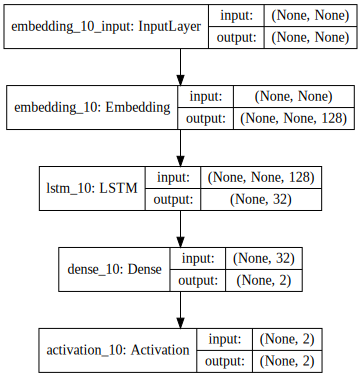

In [78]:
lstm_model = LSTMFactory().create_model(100)
SVG(model_to_dot(lstm_model, show_shapes=True).create(prog='dot', format='svg'))

La factory CNN_LSTMFactory renvoie un réseau de neurones avec cette architecture:

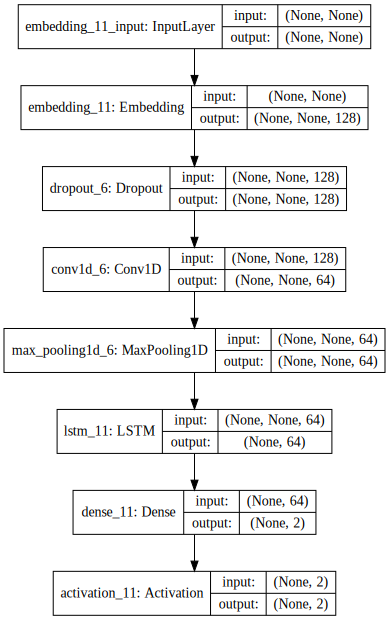

In [79]:
cnn_lstm_model = CNN_LSTMFactory().create_model(100)
SVG(model_to_dot(cnn_lstm_model, show_shapes=True).create(prog='dot', format='svg'))

### Train

On créé le pipeline avec la factory désirée, et la cardinalité de la cible. Dans notre cas, nous utiliserons la factory la plus simple, soit la LSTMFactory. La classe `TextNeuralNetPipeline` permet d'effectuer le pré-traitement du texte en séquences d'entiers, ainsi que fit/predict.

In [90]:
model = TextNeuralNetPipeline(text2seq=Text2Sequence(stemmer=FrenchStemmer()), factory_class=LSTMFactory, num_labels=2)

In [91]:
model.fit(X_train, y_train, 
                        epochs=5,
                        batch_size=100,
                        shuffle=True)

Epoch 1/5
4682/4682 [==============================] - 9s 2ms/step - loss: 0.6210 - acc: 0.6632

TextNeuralNetPipeline(factory_class=None, num_labels=2,
           text2seq=Text2Sequence(pad_string='', stemmer=<FrenchStemmer>,
       tokenizer=<nltk.tokenize.treebank.TreebankWordTokenizer object at 0x1198aa490>))

### Predict and metrics

In [92]:
from sklearn import metrics

In [93]:
y_pred = model.predict(X_test)

In [94]:
average = 'binary'
precision_score = metrics.precision_score(y_test.astype('int'), y_pred, average=average)
recall_score = metrics.recall_score(y_test.astype('int'), y_pred, average=average)
f_score = metrics.f1_score(y_test.astype('int'), y_pred, average=average)

In [95]:
print("Precision : " + str(precision_score))
print("Recall : " + str(recall_score))
print("F-Score : " + str(f_score))

Precision : 0.6469002695417789
Recall : 0.631578947368421
F-Score : 0.6391478029294273


In [96]:
y_pred_proba = model.predict_proba(X_test)

In [97]:
fpr, tpr, _ = metrics.roc_curve(y_test.astype('int'), y_pred_proba[:,1])

In [98]:
metrics.auc(fpr, tpr)

0.8218843569099741

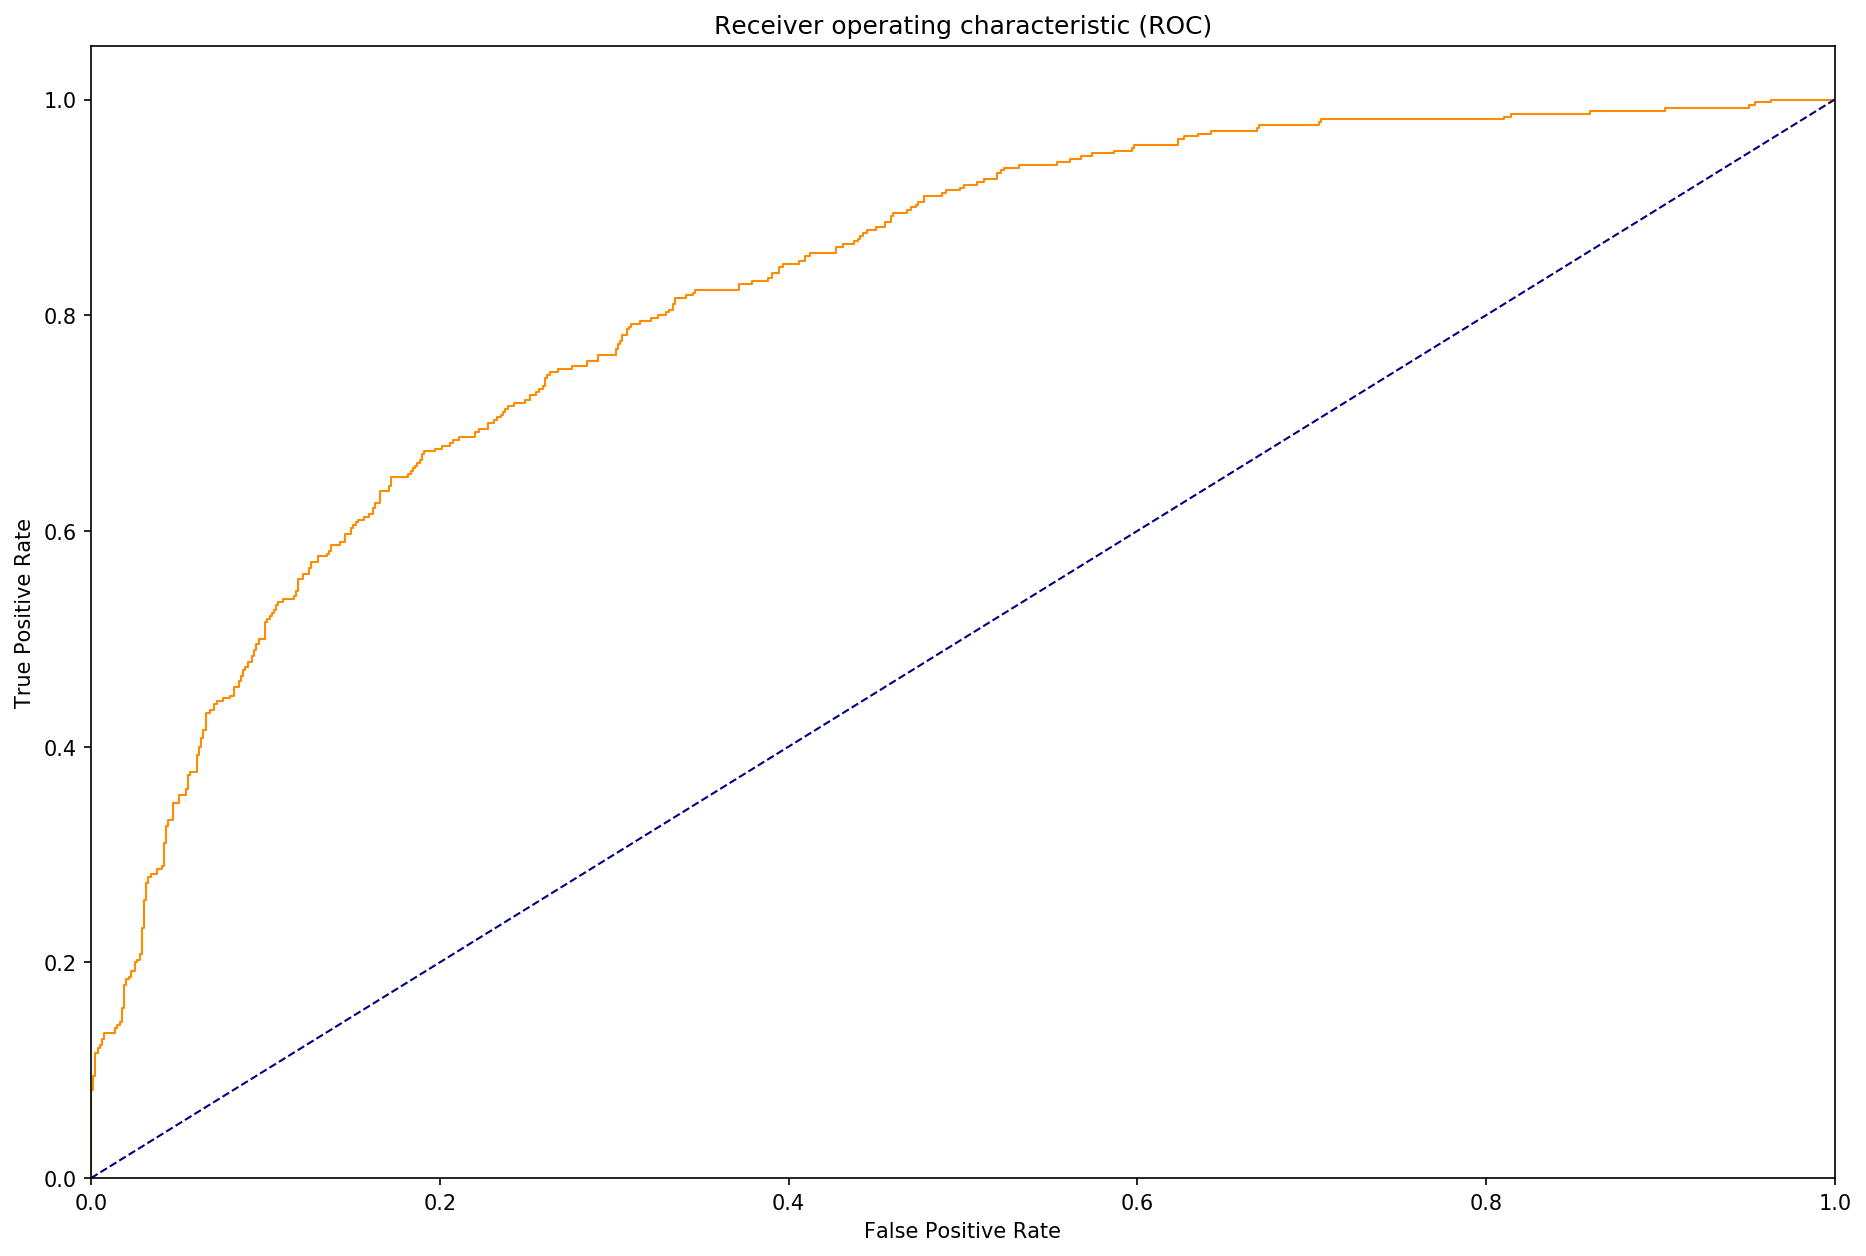

In [99]:
lw=1
plt.plot(fpr, tpr, color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.show()

### Cross validation

Avoir un pipeline complet est très pratique, cependant, on peut avoir besoin de redécomposer ce pipeline pour le découper en plus petits traitemtents (DAG Airflow) ou pour effectuer de la cross validation. Ici, on ne va transformer le texte en séquences qu'une seule fois et c'est le modèle qu'on va lancer plusieurs fois.

Extrait du code de la méthode `fit` de la classe TextNeuralNetPipeline:

```python
x = self.text2seq.fit_transform(X)
y_enc = np_utils.to_categorical(y, self.num_labels)

self.model_ = KerasClassifier(build_fn=self.factory.create_model,
                              dictionary_size=self.text2seq.dictionary_size_,
                              num_labels=self.num_labels)

self.model_.fit(x, y_enc, **kwargs)
```

Il suffit de décomposer le traitement, avec d'un côté un objet `Text2Sequence` et de l'autre un `KerasClassifier`.

In [122]:
from bdacore.neural_networks.processing import Text2Sequence

text2seq = Text2Sequence()
x = text2seq.fit_transform(X['text'])
y = X['class_cat']

In [134]:
from keras.wrappers.scikit_learn import KerasClassifier

clf_keras = KerasClassifier(build_fn=LSTMFactory().create_model,
                              dictionary_size=text2seq.dictionary_size_,
                              num_labels=2,
                              epochs=5,
                              batch_size=100, 
                              verbose=0)

On est maintenant en mesure d'effectuer la cross validation.

In [141]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

In [142]:
%%time
scores = cross_val_score(clf_keras, x.astype("int"), y.astype("int"), cv=cv, scoring='roc_auc')

CPU times: user 5min 20s, sys: 2min, total: 7min 21s
Wall time: 4min 3s


In [143]:
print(scores)
np.mean(scores)

[0.81711358 0.80548074 0.81503989 0.79785285 0.80668605]


0.8084346210006028

Le modèle est plutôt stable sur l'AUC.

#### Debrief:
Avec une approche text2seq assez simple, et un pipeline à base de LSTM, on obtient, avec le packaging proposé, des résultats rapides, le tout *sklearn compliant*, permettant tout un tas de joyeusetés, type cross validation et j'en passe, le tout avec une performance au niveau des métriques assez bonne.